# Emerging Topics -- AI

This code was created from Martha and Sean's emerging topic code and was used to create the hottest/coldest topics static graphics for the full, pandemics, and coronavirus corpora.

In [264]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [265]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import gensim
import time

from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression as lm

import matplotlib.collections as mcol
from matplotlib.legend_handler import HandlerLineCollection, HandlerTuple
from matplotlib.lines import Line2D

import seaborn as sns
import ast

import re

### Data 

In [266]:
df = pd.read_csv("/home/zz3hs/git/dspg21RnD/data_shiny/abstracts_shiny.csv")# pandemic corpus
df.reset_index(inplace=True)
df = df[df["IS_AI_BERT"] == True]

In [267]:
df

,index,PROJECT_ID,FY,PROJECT_START_DATE,PROJECT_TITLE,final_frqwds_removed,IS_AI_OECD,IS_AI_BERT,DEPARTMENT,AGENCY
0,0,812232,2015,1/13/2015,MCINTIRE-STENNIS ADMINISTRATION PROJECT,"['direct', 'identification', 'basic', 'apply',...",NaN,True,USDA,NIFA
2,2,1101885,2018,5/10/2018,REAL-TIME FORMATIVE ASSESSMENT OF NGSS MATHEMA...,"['previous', 'grant', 'award', 'ies', 'nationa...",NaN,True,ED,IES
3,3,1101875,2018,5/10/2018,GRASPABLE MATH ACTIVITIES,"['previous', 'grant', 'award', 'ies', 'graspab...",NaN,True,ED,IES
4,4,1101877,2018,5/10/2018,STRUCTURED ADAPTIVITY FOR COMPUTER SCIENCE CODING,"['team', 'prototype', 'web', 'coding', 'progre...",NaN,True,ED,IES
5,5,1101876,2018,5/10/2018,DEVELOPMENTALLY APPROPRIATE TECHNOLOGY FOR SCI...,"['prototype', 'science', 'quest', 'science', '...",NaN,True,ED,IES
...,...,...,...,...,...,...,...,...,...,...
14190,14190,1086737,2018,10/1/2018,CAREER: NEW LEARNING-BASED ALGORITHMS FOR THE ...,"['artificial_intelligence', 'fuel', 'recent', ...",True,True,NSF,NSF
14191,14191,1089879,2018,10/1/2018,SATC: CORE: FRONTIER: COLLABORATIVE: END-TO-EN...,"['frontier', 'trustworthy', 'machine_learning'...",NaN,True,NSF,NSF
14194,14194,676893,2014,9/5/2014,"MODEL PREDICTIVE CONTROL OF AN UNDERDAMPED, PN...","['predictive', 'underdamped', 'pneumatically_a...",NaN,True,NASA,NASA
14195,14195,1073868,2018,9/5/2018,ELUCIDATING THE NEURAL SUBSTRATE FOR VALUE-BAS...,"['order', 'optimal', 'value', 'decision', 'ani...",NaN,True,HHS,NIH


In [268]:
docs = df["final_frqwds_removed"]

clean_docs = []
for doc in docs:
    doc = ast.literal_eval(doc)
    clean_docs.append(doc)

In [269]:
text = []

for abstract in clean_docs:
    text.append(" ".join(abstract))

In [270]:
text[0]

'direct identification basic apply scientific implementation ensure optimum management forest administration scientist discipline'

### Functions needed for all models

In [271]:
# function slightly modified from https://nlpforhackers.io/topic-modeling/

def print_topics(topic_term_mat, vectorizer, top_n=10):
    for idx, topic in enumerate(topic_term_mat):  # loop through each row of H.  idx = row index.  topic = actual row
        print("\nTopic %d:" % (idx))
        #print([(vectorizer.get_feature_names()[i], topic[i])  # printing out words corresponding to indices found in next line
                        #for i in topic.argsort()[:-top_n - 1:-1]])  # finding indices of top words in topic
            
        print_list = [(vectorizer.get_feature_names()[i], topic[i])  
                        for i in topic.argsort()[:-top_n - 1:-1]]
        for item in print_list:
            print(item)
        

In [272]:
# Function to format topics as a "list of list of strings".
# Needed for topic coherence function in Gensim

# function modified from https://nlpforhackers.io/topic-modeling/

def str_topics(topic_term_mat, vectorizer, top_n=10):

    #input. top_n: how many words to list per topic.  If -1, then list all words.
       
    topic_words = []
    
    for idx, topic in enumerate(topic_term_mat):  # loop through each row of H.  idx = row index.  topic = actual row
            
        if top_n == -1:   
            topic_words.append([vectorizer.get_feature_names()[i] for i in topic.argsort()[::-1]])
        else:
            topic_words.append([vectorizer.get_feature_names()[i] for i in topic.argsort()[:-top_n - 1:-1]])
    
    str_wds = []
    
    for wds in topic_words:
        str_wds.append(", ".join(wds))    
    
    return str_wds 

## NMF
- Optimal Model: full dataset, 75 topics, random_state = 14
- Pandemic Model: pandemic dataset, 30, random_state = 1
- Coronavirus Model: coronavirus dataset, 30, random_state = 1

In [273]:
# use for full dataset
#tfidf_vectorizer = TfidfVectorizer(max_df=0.6, min_df=20, lowercase=False, max_features=int(len(docs)/2))
#tf_idf = tfidf_vectorizer.fit_transform(text)

# use for pandemic or coronavirus dataset
tfidf_vectorizer = TfidfVectorizer(max_df=1.0, min_df=3, lowercase=False)
tf_idf = tfidf_vectorizer.fit_transform(text)


In [274]:
# create model

num_topics = 30

t1 = time.time()
nmf_model = NMF(n_components=num_topics, random_state = 1)
doc_topic = nmf_model.fit_transform(tf_idf)
t2 = time.time()
print(f"  Model time: {t2-t1}")

topic_term = nmf_model.components_

  Model time: 5.012850284576416


### Emerging Topics

In [275]:
df['PROJECT_START_DATE']

0        1/13/2015
2        5/10/2018
3        5/10/2018
4        5/10/2018
5        5/10/2018
           ...    
14190    10/1/2018
14191    10/1/2018
14194     9/5/2014
14195     9/5/2018
14201    9/10/2013
Name: PROJECT_START_DATE, Length: 7658, dtype: object

In [276]:
from datetime import datetime
project_start_date = df["PROJECT_START_DATE"]
project_start_date = pd.to_datetime(project_start_date)
df["START_YEAR"] = project_start_date.dt.year
df = df[df.START_YEAR.notnull()]
sum(df['PROJECT_START_DATE'].isna())

0

In [277]:
df['START_YEAR'].value_counts(dropna=False)

2018.0    720
2016.0    692
2017.0    673
2009.0    652
2015.0    646
2012.0    621
2010.0    603
2014.0    592
2013.0    558
2011.0    527
2008.0    517
2007.0     92
2019.0     73
2004.0     65
2006.0     35
2005.0     34
2002.0     24
2001.0     17
1997.0     14
2000.0     14
2003.0     12
1998.0     12
1991.0     11
1999.0     10
1989.0      8
1986.0      6
1996.0      6
1994.0      5
1995.0      4
1984.0      3
1992.0      3
1993.0      3
1979.0      1
1988.0      1
1978.0      1
Name: START_YEAR, dtype: int64

In [278]:
#Pulls sample data subsetted by year then takes mean theta for each abstract
topic_frame = pd.DataFrame(doc_topic, columns=["Topic"+" "+str(i) for i in range(num_topics)])
topic_frame["START_YEAR"] = df["START_YEAR"]

In [279]:
topic_frame

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,...,Topic 21,Topic 22,Topic 23,Topic 24,Topic 25,Topic 26,Topic 27,Topic 28,Topic 29,START_YEAR
0,0.000000,0.002461,0.000000,0.000000,0.000000,0.047575,0.000000,0.000000,0.003000,0.004391,...,0.001937,0.000000,0.000425,0.006320,0.000000,0.002026,0.000000,0.000000,0.000037,2015.0
1,0.000000,0.000000,0.000000,0.139384,0.000000,0.029651,0.003041,0.000000,0.000000,0.000000,...,0.000000,0.001846,0.006006,0.000000,0.000000,0.002856,0.000000,0.000000,0.000000,NaN
2,0.000000,0.001527,0.000000,0.150683,0.000000,0.000000,0.000000,0.000028,0.000165,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.024278,0.000000,0.000000,0.000000,0.001230,2018.0
3,0.000000,0.006192,0.001247,0.094503,0.000000,0.005480,0.000000,0.000688,0.004800,0.000000,...,0.000857,0.000332,0.001102,0.003088,0.016761,0.000000,0.000000,0.000000,0.000000,2018.0
4,0.000000,0.000000,0.000000,0.156159,0.000000,0.029354,0.000000,0.000345,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003866,0.001069,2018.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7653,0.008748,0.000000,0.000694,0.005345,0.000000,0.000000,0.000000,0.000000,0.020923,0.007464,...,0.000000,0.005127,0.029929,0.000000,0.000000,0.002013,0.000000,0.000000,0.000000,2010.0
7654,0.013665,0.000000,0.002710,0.016083,0.000596,0.011884,0.001126,0.000000,0.002709,0.011219,...,0.000256,0.014788,0.000000,0.000000,0.013463,0.001099,0.017361,0.000465,0.000000,NaN
7655,0.000000,0.000000,0.133021,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2006.0
7656,0.000000,0.039000,0.000000,0.000000,0.000000,0.000000,0.114714,0.000000,0.000000,0.005725,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN


### compute count of projects with weight > 0 for each topic

In [280]:
topic_proj_count = topic_frame.copy()

topic_count_bool = (topic_proj_count.iloc[:,0:num_topics] > 0)
topic_count_bool["START_YEAR"] = topic_proj_count["START_YEAR"]


# same calculation but grouped by year

topic_counts = topic_count_bool.groupby("START_YEAR").sum().reset_index()
topic_counts = topic_counts.sort_values(by = "START_YEAR")  # pretty sure this is unnecessary
topic_counts["START_YEAR"] = topic_counts["START_YEAR"].astype(int)

#topic counts
topic_counts_filt = topic_counts[topic_counts["START_YEAR"] > 2009] 
topic_counts_filt = topic_counts_filt[topic_counts_filt["START_YEAR"] < 2019]  # NO NSF DATA from 2019, was 2020

topic_counts_filt


,START_YEAR,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,...,Topic 20,Topic 21,Topic 22,Topic 23,Topic 24,Topic 25,Topic 26,Topic 27,Topic 28,Topic 29
24,2010,175,125,125,153,126,161,140,129,160,...,129,114,147,153,130,141,133,135,131,148
25,2011,111,91,81,121,103,127,111,86,127,...,84,70,122,121,98,108,90,98,91,99
26,2012,148,113,112,142,125,169,144,109,147,...,112,112,138,136,131,148,111,110,117,126
27,2013,117,81,78,105,82,127,113,85,111,...,89,101,105,144,103,118,96,101,75,96
28,2014,123,88,90,116,91,126,111,87,128,...,94,91,124,106,90,116,98,118,104,106
29,2015,135,111,116,141,104,145,138,103,145,...,102,109,139,139,116,133,103,131,122,127
30,2016,207,150,160,175,147,200,178,154,186,...,158,132,192,165,159,175,151,144,155,151
31,2017,177,132,119,154,122,169,168,122,149,...,132,118,158,145,134,160,137,120,119,146
32,2018,145,117,121,157,127,177,145,128,152,...,119,121,137,145,113,160,120,117,141,139


In [281]:
#TODO: counts by topic
n_by_topic = topic_counts_filt.sum()[1:]

n_by_topic

Topic 0     1338
Topic 1     1008
Topic 2     1002
Topic 3     1264
Topic 4     1027
Topic 5     1401
Topic 6     1248
Topic 7     1003
Topic 8     1305
Topic 9     1290
Topic 10    1167
Topic 11     906
Topic 12    1399
Topic 13    1316
Topic 14    1164
Topic 15    1280
Topic 16    1005
Topic 17    1151
Topic 18    1045
Topic 19     975
Topic 20    1019
Topic 21     968
Topic 22    1262
Topic 23    1254
Topic 24    1074
Topic 25    1259
Topic 26    1039
Topic 27    1074
Topic 28    1055
Topic 29    1138
dtype: int64

### Calculate mean topic weight by year and standard errors on means

In [282]:
topic_frame_se = topic_frame.groupby("START_YEAR").sem().reset_index()
topic_frame_se = topic_frame_se.sort_values(by = "START_YEAR")
topic_frame_se["START_YEAR"] = topic_frame_se["START_YEAR"].astype(int)

topic_wts_se_2010_2019 = topic_frame_se[topic_frame_se["START_YEAR"] > 2009] 
topic_wts_se_2010_2019 = topic_wts_se_2010_2019[topic_wts_se_2010_2019["START_YEAR"] < 2019] #TODO: change the upper limit to 2019

In [283]:
topic_frame = topic_frame.groupby("START_YEAR").mean().reset_index()
topic_frame = topic_frame.sort_values(by = "START_YEAR")
topic_frame["START_YEAR"] = topic_frame["START_YEAR"].astype(int)

In [284]:
topic_frame.head()

,START_YEAR,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,...,Topic 20,Topic 21,Topic 22,Topic 23,Topic 24,Topic 25,Topic 26,Topic 27,Topic 28,Topic 29
0,1979,0.011671,0.000000,0.005382,0.011667,0.00000,0.026094,0.000000,0.000000,0.007605,...,0.000000,0.000000,0.000000,0.014509,0.000000,0.022262,0.000000,0.029489,0.000000,0.000000
1,1984,0.001738,0.000000,0.000889,0.004630,0.00088,0.030392,0.000270,0.000265,0.003832,...,0.025450,0.000000,0.000233,0.070953,0.001197,0.000000,0.000000,0.006569,0.001341,0.000000
2,1986,0.002435,0.000000,0.040574,0.004828,0.00000,0.024564,0.011846,0.000805,0.001842,...,0.000193,0.002846,0.001852,0.015016,0.002388,0.033797,0.005126,0.002576,0.000566,0.004365
3,1988,0.000000,0.000000,0.000000,0.000000,0.06995,0.011164,0.000000,0.002261,0.014015,...,0.012208,0.000000,0.000000,0.017612,0.000000,0.001626,0.000000,0.000000,0.000000,0.003513
4,1989,0.004678,0.009458,0.000846,0.024018,0.00337,0.016460,0.010680,0.003976,0.011657,...,0.000940,0.002413,0.001055,0.008147,0.025594,0.002754,0.019165,0.001262,0.001182,0.010905


In [285]:
# filter topic_frame for years 2010 - 2018

topic_wts_2010_2019 = topic_frame[topic_frame["START_YEAR"] > 2009] 
topic_wts_2010_2019 = topic_wts_2010_2019[topic_wts_2010_2019["START_YEAR"] < 2019] #TODO: change the upper limit to 2019

In [286]:
# perform regressions, track slopes

topic_slopes = []

for i in range(1,num_topics+1):
    linear_fit = lm().fit(topic_wts_2010_2019["START_YEAR"].values.reshape(-1,1), topic_wts_2010_2019.iloc[:,i].values.reshape(-1,1))
    
    topic_slopes.append(linear_fit.coef_[0][0])

In [287]:
topic_slopes[:5]

[-4.3525413277274694e-05,
 0.00016977632135408403,
 -5.18429678937451e-05,
 1.7558754739958685e-05,
 -0.00017327126798831293]

In [288]:
hot_cold = []

for slope in topic_slopes:
    if slope > 0:
        hot_cold.append("hot")
    else:
        hot_cold.append("cold")

In [289]:
hot_cold[:5]

['cold', 'hot', 'cold', 'hot', 'cold']

In [290]:
topic_words = str_topics(topic_term, tfidf_vectorizer, top_n=10)

In [291]:
topic_words[:5]

['algorithm, machine_learning, algorithmic, complexity, efficient, graph, theory, approximation, pi, bound',
 'neural, circuit, neuron, sensory, cortical, animal, dynamics, neuronal, behavioral, motor',
 'robot, robotics, robotic, environment, task, planning, motion, manipulation, manufacturing, autonomous',
 'student, stem, teacher, assessment, skill, school, classroom, mathematics, course, education',
 'language, natural, linguistic, processing, text, speech, translation, sentence, semantic, nlp']

In [292]:
# package up data for data table in RShiny dashboard

reg_topics = pd.DataFrame()
reg_topics["Slope"] = topic_slopes
reg_topics["Hot or Cold"] = hot_cold
reg_topics["Topic Words"] = topic_words 


In [293]:
reg_topics

,Slope,Hot or Cold,Topic Words
0,-0.000044,cold,"algorithm, machine_learning, algorithmic, comp..."
1,0.000170,hot,"neural, circuit, neuron, sensory, cortical, an..."
2,-0.000052,cold,"robot, robotics, robotic, environment, task, p..."
3,0.000018,hot,"student, stem, teacher, assessment, skill, sch..."
4,-0.000173,cold,"language, natural, linguistic, processing, tex..."
5,-0.000076,cold,"science, scientific, innovation, policy, scien..."
6,0.000069,hot,"decision, choice, value, decision_making, rewa..."
7,0.000103,hot,"visual, object, vision, recognition, perceptio..."
8,-0.000032,cold,"software, code, developer, verification, progr..."
9,-0.000265,cold,"statistical, dimensional, inference, variable,..."


In [294]:
#reg_topics.to_csv("./full_topics.csv", index=False)
#reg_topics.to_csv("./pan_topics.csv", index=False)
#reg_topics.to_csv("./cor_topics.csv", index=False)

## Create plot - top 5 hot and cold topics

In [295]:
# Sean's plots - legend

leg = str_topics(topic_term, tfidf_vectorizer, top_n=5)

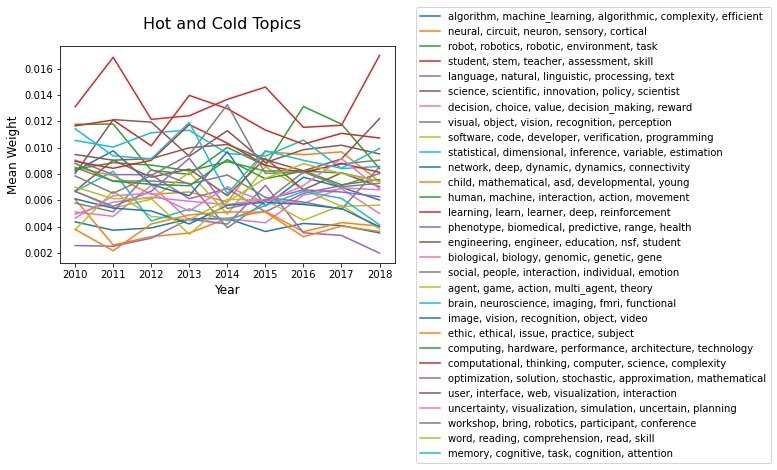

In [296]:
#Make Graphs
#leg = []
topic_results = {}
fig = plt.figure()
fig.suptitle('Hot and Cold Topics', fontsize=16)
ax = fig.add_subplot(111)

for i in range(1,num_topics+1):
    linear_fit = lm().fit(topic_wts_2010_2019["START_YEAR"].values.reshape(-1,1), topic_wts_2010_2019.iloc[:,i].values.reshape(-1,1))
    topic_results[i] = linear_fit.coef_[0][0]
    ax.plot(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019.iloc[:,i])
    #leg.append("Topic %d"%(n+1))

plt.xticks(np.arange(topic_wts_2010_2019["START_YEAR"].min(), topic_wts_2010_2019["START_YEAR"].max()+1, 1.0))
plt.xlabel('Year', fontsize=12)
plt.ylabel('Mean Weight', fontsize=12)
#ax.yaxis.set_label_coords(-0.14,0.5)
plt.legend(leg,bbox_to_anchor=(1.05, 1.0, 0.3, 0.2), loc='upper left')
plt.show()

In [297]:
class HandlerDashedLines(HandlerLineCollection):
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        # figure out how many lines there are
        numlines = len(orig_handle.get_segments())
        xdata, xdata_marker = self.get_xdata(legend, xdescent, ydescent,
                                             width, height, fontsize)
        leglines = []
        # divide the vertical space where the lines will go
        # into equal parts based on the number of lines
        ydata = np.full_like(xdata, height / (numlines + 1))
        # for each line, create the line at the proper location
        # and set the dash pattern
        for i in range(numlines):
            legline = Line2D(xdata, ydata * (numlines - i) - ydescent)
            self.update_prop(legline, orig_handle, legend)
            # set color, dash pattern, and linewidth to that
            # of the lines in linecollection
            try:
                color = orig_handle.get_colors()[i]
            except IndexError:
                color = orig_handle.get_colors()[0]
            try:
                dashes = orig_handle.get_dashes()[i]
            except IndexError:
                dashes = orig_handle.get_dashes()[0]
            try:
                lw = orig_handle.get_linewidths()[i]
            except IndexError:
                lw = orig_handle.get_linewidths()[0]
            if dashes[0] is not None:
                legline.set_dashes(dashes[1])
            legline.set_color(color)
            legline.set_transform(trans)
            legline.set_linewidth(lw)
            leglines.append(legline)
        return leglines


In [298]:
def sort_dict(x):
    return sorted(x.items(), key=lambda l: l[1], reverse=True)

In [299]:
sort_slopes = sort_dict(topic_results)
top_slopes = [x[0] for x in sort_slopes[:5]]
bottom_slopes = [x[0] for x in sort_slopes[-5:]]

sort_slopes[:5]

[(27, 0.00031946711183835274),
 (29, 0.0002838601131947855),
 (2, 0.00016977632135408403),
 (17, 0.00016412989736315728),
 (26, 0.0001410162739463811)]

## Plot for each topic in a grid

In [300]:
# get order of plots

sorted_slopes = [x[0] for x in sort_slopes]
sorted_slopes # indices from 1 to 30

# leg: indices 0-29

[27,
 29,
 2,
 17,
 26,
 8,
 18,
 7,
 15,
 22,
 4,
 12,
 23,
 25,
 28,
 9,
 19,
 1,
 16,
 3,
 6,
 21,
 24,
 13,
 14,
 5,
 30,
 20,
 10,
 11]

In [301]:
# set new legend with \n inserted into each entry

new_leg = []

for title in leg:
    
    # find commas in each title
    commas = [match.start() for match in re.finditer(',', title)]
    idx = commas[2] + 1
    
    # insert '\n' after third comma
    new_leg.append(title[:idx] + ' \n' + title[idx:])

In [302]:
new_leg

['algorithm, machine_learning, algorithmic, \n complexity, efficient',
 'neural, circuit, neuron, \n sensory, cortical',
 'robot, robotics, robotic, \n environment, task',
 'student, stem, teacher, \n assessment, skill',
 'language, natural, linguistic, \n processing, text',
 'science, scientific, innovation, \n policy, scientist',
 'decision, choice, value, \n decision_making, reward',
 'visual, object, vision, \n recognition, perception',
 'software, code, developer, \n verification, programming',
 'statistical, dimensional, inference, \n variable, estimation',
 'network, deep, dynamic, \n dynamics, connectivity',
 'child, mathematical, asd, \n developmental, young',
 'human, machine, interaction, \n action, movement',
 'learning, learn, learner, \n deep, reinforcement',
 'phenotype, biomedical, predictive, \n range, health',
 'engineering, engineer, education, \n nsf, student',
 'biological, biology, genomic, \n genetic, gene',
 'social, people, interaction, \n individual, emotion',

# 10 topics

# 20 topics

# 30 topics 

### Descriptive statistics on corpus

In [42]:
df["START_YEAR"].value_counts()

2008    107
2009     91
2010     89
2015     74
2011     71
2013     68
2016     63
2012     60
2014     59
2017     51
2018     45
2007     30
2019     30
2005     25
2004     18
2006     17
2001      9
1997      6
1985      5
1991      5
2002      5
1998      4
2003      4
1987      3
1981      3
1988      2
1980      2
1999      2
1975      2
1990      2
1977      1
1996      1
1979      1
1992      1
2000      1
Name: START_YEAR, dtype: int64

In [43]:
df["DEPARTMENT"].value_counts()

HHS     864
USDA     56
NSF      25
NASA      5
DOD       4
VA        3
Name: DEPARTMENT, dtype: int64

In [44]:
# filter data frame by year and repeat descriptive statistics.  Limit years to those for emerging topic analysis.

filt_df = df.copy()
filt_df["START_YEAR"] = filt_df["START_YEAR"].astype('int')

filt_df = filt_df[filt_df["START_YEAR"] > 2009]
filt_df = filt_df[filt_df["START_YEAR"] < 2020]

In [48]:
filt_df["START_YEAR"].value_counts().sort_index()

2010    89
2011    71
2012    60
2013    68
2014    59
2015    74
2016    63
2017    51
2018    45
2019    30
Name: START_YEAR, dtype: int64

In [46]:
filt_df["DEPARTMENT"].value_counts()

HHS     544
USDA     34
NSF      21
DOD       4
NASA      4
VA        3
Name: DEPARTMENT, dtype: int64

In [47]:
filt_df.pivot_table(index=['DEPARTMENT','START_YEAR'], aggfunc='size')

DEPARTMENT  START_YEAR
DOD         2015           1
            2018           1
            2019           2
HHS         2010          80
            2011          69
            2012          55
            2013          55
            2014          51
            2015          63
            2016          52
            2017          49
            2018          42
            2019          28
NASA        2010           1
            2015           2
            2016           1
NSF         2010           2
            2012           3
            2013           3
            2014           2
            2015           2
            2016           6
            2017           1
            2018           2
USDA        2010           5
            2011           1
            2012           2
            2013           9
            2014           6
            2015           6
            2016           4
            2017           1
VA          2010           1
            2011    